<div>
<img src="https://drive.google.com/uc?export=view&id=1vK33e_EqaHgBHcbRV_m38hx6IkG0blK_" width="350"/>
</div> 

#**Artificial Intelligence - MSc**
##ET5003 - MACHINE LEARNING APPLICATIONS 

###Instructor: Enrique Naredo
###ET5003_Etivity-2

In [1]:
# @title Current Date
Today = "2021-09-26"  # @param {type:"date"}

In [2]:
# @markdown ---
# @markdown ### Enter your details here:
Student_ID = "20151586"  # @param {type:"string"}
Student_full_name = "Carlos Siqueira do Amaral"  # @param {type:"string"}
# @markdown ---

In [3]:
# @title Notebook information
Notebook_type = "Assignment"  # @param ["Example", "Lab", "Practice", "Etivity", "Assignment", "Exam"]
Version = "Draft"  # @param ["Draft", "Final"] {type:"raw"}
Submission = False  # @param {type:"boolean"}

# INTRODUCTION

**Piecewise regression**, extract from [Wikipedia](https://en.wikipedia.org/wiki/Segmented_regression):

Segmented regression, also known as piecewise regression or broken-stick regression, is a method in regression analysis in which the independent variable is partitioned into intervals and a separate line segment is fit to each interval. 

* Segmented regression analysis can also be performed on 
multivariate data by partitioning the various independent variables. 
* Segmented regression is useful when the independent variables, clustered into different groups, exhibit different relationships between the variables in these regions. 

* The boundaries between the segments are breakpoints.

* Segmented linear regression is segmented regression whereby the relations in the intervals are obtained by linear regression. 

***The goal is to use advanced Machine Learning methods to predict House price.***

## Imports

In [4]:
import os
import pandas as pd
import numpy as np
import pymc3 as pm
import arviz as az
import theano as tt

# to plot
import matplotlib.colors
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm


# Sklearn
import sklearn.datasets as dt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.pipeline import Pipeline

# Custom notebook style
from jupyterthemes import jtplot as jt

# MLflow to track metrics
from datetime import datetime
import mlflow
from mlflow import log_metric, log_param

runtime = datetime.now().strftime("%Y%m%d_%H%M%S")
mlflow.set_experiment(runtime)


jt.style()
%matplotlib inline
%load_ext lab_black

print(f"pymc3 version: {pm.__version__}")
print(f"arviz version: {az.__version__}")
print(f"theano version: {tt.__version__}")
!python --version

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


INFO: '20211002_133905' does not exist. Creating a new experiment
pymc3 version: 3.11.4
arviz version: 0.11.2
theano version: 1.1.2
Python 3.7.11


In [5]:
# Define the seed so that results can be reproduced
seed = 11
rand_state = 1

# Define the color maps for plots
# color_map = plt.cm.get_cmap('RdYlBu')
# color_map_discrete = matplotlib.colors.LinearSegmentedColormap.from_list("", ["red","cyan","magenta","blue"])

# DATASET

Extract from this [paper](https://ieeexplore.ieee.org/document/9300074):

* House prices are a significant impression of the economy, and its value ranges are of great concerns for the clients and property dealers. 

* Housing price escalate every year that eventually reinforced the need of strategy or technique that could predict house prices in future. 

* There are certain factors that influence house prices including physical conditions, locations, number of bedrooms and others.


1. [Download the dataset](https://github.com/UL-ET5003/ET5003_SEM1_2021-2/tree/main/Week-3). 

2. Upload the dataset into your folder.



The challenge is to predict the final price of each house.

# Data Preparation

## Loading datasets

In [6]:
fpath = os.path.join(os.getcwd(), "house_prices")

train_fname = "house_train.csv"
test_fname = "house_test.csv"
cost_fname = "true_price.csv"

train_set = pd.read_csv(os.path.join(fpath, train_fname)).drop(columns="ad_id")
X_test = pd.read_csv(os.path.join(fpath, test_fname)).drop(columns="ad_id")
y_test = pd.read_csv(os.path.join(fpath, cost_fname)).drop(columns="Id")

print("Loaded training data of shape", train_set.shape)
print("Loaded test data of shape", X_test.shape)
print("Loaded cost data of shape", y_test.shape)

Loaded training data of shape (2982, 16)
Loaded test data of shape (500, 15)
Loaded cost data of shape (500, 1)


There are some entries with null values for `price` in the training set, let's remove them


In [7]:
print("Training set rows with no house price:", train_set["price"].isna().sum())

train_set = train_set[train_set["price"].notna()]

Training set rows with no house price: 90


In [8]:
train_set.sample(5)

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface
818,Swords,3.0,4.0,NaN,Dublin,Brophy Estates are delighted to bring to the m...,prod,"Parking,Gas Fired Central Heating,Wired for Ca...",4 Bed Detached House\nSouth facing\nOpen plan ...,53.454933,-6.259684,NaN,565000.0,sale,detached,188.0
2977,Ballsbridge,2.0,2.0,C3,Dublin,Sherry FitzGerald are delighted to present Apa...,prod,NaN,Prime Location\nManagement Co: Core Property M...,53.338738,-6.237199,NaN,415000.0,sale,apartment,56.0
802,Glasnevin,1.0,3.0,D2,Dublin,Mason Estates present this fine extended three...,prod,"Parking,Gas Fired Central Heating",Extended accommodation\nTriple glazed uPVC win...,53.389930,-6.283289,NaN,385000.0,sale,semi-detached,97.0
2318,Stepaside,3.0,3.0,A3,Dublin,"Welcome to No. 6 Cotter Close, an immaculately...",prod,NaN,Special Features\nLarge rear garden\nGenerous ...,53.266468,-6.222771,NaN,535000.0,sale,semi-detached,107.0
2669,Castleknock,1.0,3.0,C3,Dublin,Branagan Estates are pleased to offer this 3 b...,prod,NaN,None,53.370798,-6.398873,NaN,389950.0,sale,semi-detached,81.0


## Data Exploration

Some features that could influence house price are more or less intuitive, for example:
- area (which could also be encoded with latitude/longitude)
- bathrooms
- beds
- surface

But there are other features which need further analysis to decide whether they should be included or not.
- ber_classification
- property_type
- property_category
What are some features that could possibly be useful?

There's also the case of `facility` which could be interesting to analyse but has many values and could add noise.

In [9]:
def add_labels_barh(x, y, axis, **kwargs):
    """Adds label values to a horizontal barplot
    
    Parameters
    ----------
    x : pd.Series
        Heights of the bars
    y : pd.Series
        The value labels of each bar
    axis : matplotlib.pyplot.axis
        The axes to plot
    
    Returns
    -------
    None
    """
    for y_pos, x_pos in enumerate(x):
        axis.text(x_pos + 2, y_pos - 0.2, y[y_pos], **kwargs)


def format_prices(x):
    """Helper function to format the mean and median house prices to text.
    To be used as part of a pd.Series.apply method.

    Parameters
    ----------
    x : iterable
        Pair containing mean and median house prices, respectively
    
    Returns
    -------
        A string with the formatted prices, in hundred thousands

    """
    mean, median = x
    return f"({mean/100_000:.1f}K, {median/100_000:,.1f}K)"


def agg_count_plot(data, feature, target, ax, **plot_kwargs):
    """Aggregates data on a given feature, and creates a horizontal bar plot
    labelled with the mean and median of the target feature in hundreds of thousands

    Parameters
    ----------
    data : pd.DataFrame
        Data to aggregate.
    feature : str
        Name of Data column to analyse.
    target : str
        Name of data column with target variable
    ax : matplotlib.pyplot.axis
        The axes to plot
        
    Returns
    -------
    None
    """
    agg_df = (
        data[[feature, target]]
        .groupby(feature)
        .agg(
            count=(feature, "count"),
            mean_price=(target, "mean"),
            median_price=(target, "median"),
        )
    )

    agg_df["count"].sort_index(ascending=False).plot(kind="barh", ax=ax, **plot_kwargs)
    add_labels_barh(
        agg_df["count"][::-1],
        agg_df[[f"mean_{target}", f"median_{target}"]].apply(format_prices, axis=1)[
            ::-1
        ],
        ax,
    )
    ax.set_ylabel("")

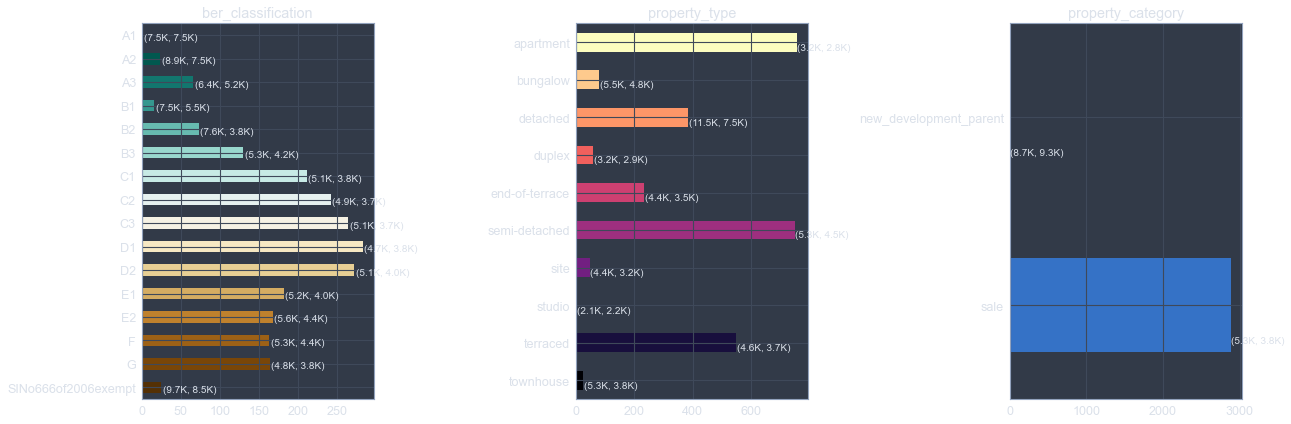

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Plot for ber classification
unique_ber = train_set["ber_classification"].nunique()
ber_cmap = cm.get_cmap("BrBG", unique_ber)
ber_colors = [ber_cmap(i) for i in range(unique_ber)]
agg_count_plot(
    train_set,
    "ber_classification",
    "price",
    ax=axes[0],
    color=ber_colors,
    title="ber_classification",
)

unique_types = train_set["property_type"].nunique()
type_cmap = cm.get_cmap("magma", unique_types)
type_colors = [type_cmap(i) for i in range(unique_types)]
agg_count_plot(
    train_set,
    "property_type",
    "price",
    ax=axes[1],
    title="property_type",
    color=type_colors,
)

agg_count_plot(
    train_set, "property_category", "price", ax=axes[2], title="property_category"
)

fig.tight_layout()
plt.show()

Some notes:

`ber_classification` and `property_type` do seem to have some impact on the mean and median house prices at different levels, while the class imbalance of `property_category` types makes it hard to make any conclusions. The `ber_classification` price varies a bit, while `property_type` has  bigger rance between mean and median values.

I'll encode `ber_classification` and `property_type` and use these as features.

In [11]:
train_set["county"].value_counts()

Dublin    2892
Name: county, dtype: int64

As there are only entries for Dublin, the feature `county` is not useful.

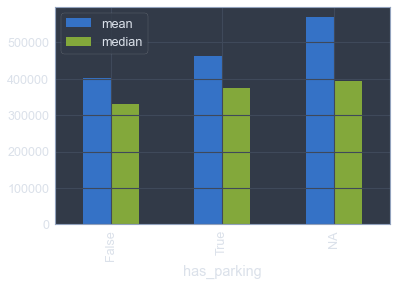

NA       1942
True      839
False     111
Name: has_parking, dtype: int64

In [12]:
train_set["has_parking"] = train_set["facility"].str.contains("Parking").fillna("NA")
train_set.groupby("has_parking")["price"].agg(["mean", "median"]).plot(kind="bar")
plt.show()

train_set["has_parking"].value_counts()

Looks like there's also a slight difference in the prices of houses that have parking and those that don't, but there are many missing values for this feature, so I won't use it either.

### Latitude / Longitude

An inspection of these variables showed two entries that appear to have been incorrectly input as they point to places outside of Ireland

In [13]:
train_set[train_set["latitude"] < 53]

,area,bathrooms,beds,ber_classification,county,description_block,environment,facility,features,latitude,longitude,no_of_units,price,property_category,property_type,surface,has_parking
767,Clondalkin,1.0,3.0,NaN,Dublin,RAY COOKE AUCTIONEERS take great pleasure in i...,prod,NaN,None,52.501856,-1.744995,NaN,199000.0,sale,semi-detached,79.0,NA
861,Glenageary,2.0,4.0,F,Dublin,LEONARD WILSON KEENAN ESTATE &amp; LETTING AGE...,prod,NaN,None,51.458439,-2.496219,NaN,795000.0,sale,semi-detached,NaN,NA


In [14]:
# Remove wrong entries
train_set = train_set[train_set["latitude"] > 53]

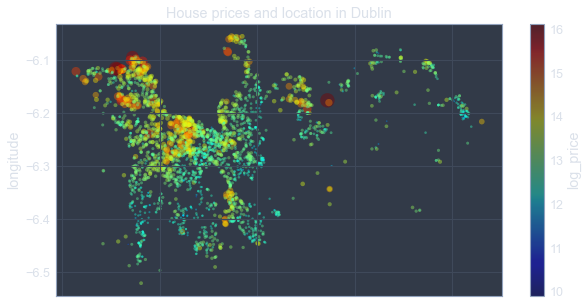

In [15]:
train_set.loc[:, "log_price"] = np.log(train_set.loc[:, "price"],)
train_set.plot.scatter(
    "latitude",
    "longitude",
    s=train_set["price"] / 50_000,
    c="log_price",
    cmap="jet",
    figsize=(10, 5),
    alpha=0.4,
)
plt.xlabel("latitude")
plt.title("House prices and location in Dublin")
plt.show()

Instead of encoding `area` for feature, I'll use Latitude and longitude instead, as this can be a way to differentiate on house prices.

## Feature engineering

Encoding categorical variables and scaling.

In [16]:
drop_cols = [
    "area",
    "county",
    "description_block",
    "environment",
    "facility",
    "features",
    "has_parking",
    "no_of_units",
    "property_category",
    "price",
]
train_set = train_set.drop(columns=drop_cols)
train_set.head()

,bathrooms,beds,ber_classification,latitude,longitude,property_type,surface,log_price
15,3.0,5.0,A3,53.400454,-6.445730,detached,321.0,13.748302
26,4.0,4.0,A3,53.316410,-6.385214,semi-detached,144.0,13.091904
27,3.0,5.0,A3,53.401414,-6.446634,detached,321.0,13.748302
35,5.0,5.0,A2,53.375377,-6.056749,detached,312.0,14.204169
38,2.0,2.0,A3,53.372130,-6.338466,apartment,83.0,12.923912


Train / test split

In [17]:
num_cols = ["bathrooms", "beds", "latitude", "longitude", "surface"]
one_hot_cols = ["property_type"]
ordinal_cols = ["ber_classification"]
column_order = num_cols + ordinal_cols + one_hot_cols

train_set = train_set[column_order + ["log_price"]].dropna(axis=0)

X_train, y_train = (
    train_set.drop(columns=["log_price"]),
    train_set["log_price"].copy().values,
)

X_test = X_test[column_order].drop(columns=drop_cols, errors="ignore")
y_test = np.log(y_test.copy())

print("Split training data:")
print("\tX_train shape:", X_train.shape)
print("\tX_test shape:", X_test.shape)

Split training data:
	X_train shape: (2002, 7)
	X_test shape: (500, 7)


### Feature scaling

In [18]:
scaler = StandardScaler()
y_scaler = StandardScaler()
ordinal_enc = OrdinalEncoder(handle_unknown="use_encoded_value", unknown_value=-1)
one_hot_enc = OneHotEncoder(sparse=False)

X_train_scaled = X_train.reset_index(drop=True).copy()
X_test_scaled = X_test.copy()

# Fit and transform training set
X_train_scaled[num_cols] = scaler.fit_transform(X_train_scaled[num_cols])
X_train_scaled[ordinal_cols] = ordinal_enc.fit_transform(X_train_scaled[ordinal_cols])
X_one_hot = one_hot_enc.fit_transform(X_train_scaled[one_hot_cols])
X_one_hot = pd.DataFrame(X_one_hot, columns=one_hot_enc.categories_)
X_train_scaled = pd.concat(
    [X_train_scaled.drop(columns=one_hot_cols), X_one_hot], axis=1, ignore_index=True
).to_numpy(dtype=np.float32)

# Transform test set
X_test_scaled[num_cols] = scaler.transform(X_test_scaled[num_cols])
X_test_scaled[ordinal_cols] = ordinal_enc.transform(X_test[ordinal_cols])
X_one_hot = one_hot_enc.transform(X_test_scaled[one_hot_cols])
X_one_hot = pd.DataFrame(X_one_hot, columns=one_hot_enc.categories_)
X_test_scaled = pd.concat(
    [X_test_scaled.drop(columns=one_hot_cols), X_one_hot], axis=1, ignore_index=True
).to_numpy(dtype=np.float32)

# # Fit and transform train and test targets
y_train_scaled = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test_scaled = y_scaler.transform(y_test.values)

assert len(X_train_scaled) == len(y_train_scaled)
assert len(X_test_scaled) == 500
assert len(y_test_scaled) == len(X_test_scaled)

# PIECEWISE REGRESSION

## Full Model

In [19]:
X_train.columns

Index(['bathrooms', 'beds', 'latitude', 'longitude', 'surface',
       'ber_classification', 'property_type'],
      dtype='object')

In [20]:
# select some features columns just for the baseline model
# assume not all of the features are informative or useful
# in this exercise you could try all of them if possible

# Start out only with numerical features (they are the first ones in the dataset)
features = range(len(num_cols))
param_feature_names = ("features", X_train.columns[features].tolist())
log_param(*param_feature_names)
print("Using features: ", param_feature_names)
print()

X_train_subset = X_train_scaled[:, features]
print("X_train_subset shape", X_train_subset.shape)
print("y_train_scaled shape", y_train_scaled.shape)

X_test_subset = X_test_scaled[:, features]
print("X_test_subset shape", X_test_subset.shape)
print("y_test_scaled shape", y_test_scaled.shape)

Using features:  ('features', ['bathrooms', 'beds', 'latitude', 'longitude', 'surface'])

X_train_subset shape (2002, 5)
y_train_scaled shape (2002, 1)
X_test_subset shape (500, 5)
y_test_scaled shape (500, 1)


### **Note on fitting times**

I found that the shape of the observations plays a huge factor in how long it takes to fit. 

Initially I passed in `y_train_scaled` of shape `(1401, 1)` and it took over 5 minutes to fit. After reshaping to `(1401,)` fitting time was drastically reduced to a few seconds!

In [21]:
def define_lin_reg(
    predictors,
    observed,
    model_name,
    n_iterations=30_000,
    n_samples=5_000,
    alpha=("Normal", 0, 10),
    beta=("Normal", 0, 10),
    sigma=("HalfCauchy", 5),
    plot_loss=False,
):
    """Defines and trains a Bayesian linear regression model:
            mu ~ alpha + beta * predictors
    With likelihood
            likelihood ~ N(mu, sigma)
    Where alpha, beta and sigma are pymc distributions defined by the user.

    Parameters
    ----------
    predictors : np.ndarray
        Numpy array with model features.
    observed : np.ndarray
        Numpy array with observed values of the target feature. Preferably as a 1-D array
        to speed up fitting time.
    model_name : str
        Identifier for the model being defined
    n_iterations : int
        The number of iterations for fitting.
    n_samples : int
        The number of samples to draw for the posterior.
    alpha : tuple(string, int, [int, ])
        Prior distribution of alpha. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.
    beta : tuple(string, int, [int, ])
        Prior distribution of beta. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.
    sigma : tuple(string, int, [int, ])
        Prior distribution of sigma. The first argument should be a string with
        a pymc3 model followed by 1 or more integer arguments for the parameters of that distribution.

    Returns
    -------
    posterior : pymc3.backends.base.MultiTrace
        Posterior distribution estimated by pymc model.
    """
    log_param(f"{model_name}_alpha", alpha)
    log_param(f"{model_name}_beta", beta)
    log_param(f"{model_name}_sigma", sigma)
    log_param(f"{model_name}_n_iterations", n_iterations)
    log_param(f"{model_name}_n_samples", n_samples)

    with pm.Model() as model:
        alpha = getattr(pm, alpha[0])("alpha", *alpha[1:])
        beta = getattr(pm, beta[0])("beta", *beta[1:], shape=predictors.shape[1])

        mu = alpha + pm.math.dot(beta, predictors.T)

        sigma = getattr(pm, sigma[0])("sigma", *sigma[1:])
        likelihood = pm.Normal("likelihood", mu=mu, sigma=sigma, observed=observed)
        approximation = pm.fit(n_iterations, method="advi")
        posterior = approximation.sample(n_samples)
    if plot_loss:
        plt.figure(figsize=(10, 6))
        plt.plot(approximation.hist, alpha=0.7)
        plt.title("Full model loss")
        plt.xlabel("n_iterations")
        plt.ylabel("log(loss)")
        plt.yscale("log")
        plt.grid(True, which="both", axis="y", linestyle="--")
        plt.show()
    return posterior


def mean_absolute_error(y_true, y_pred):
    """Calculates the Mean Absolute Error between y_true and y_pred
    
    Parameters
    ----------
    y_true : 

    y_pred : 

    Returns
    -------
    np.ndarray
        The mean absolute error of the predictions
    """
    return np.mean(abs(y_true - y_pred))


def mape(y_true, y_pred):
    """Calculates the MAPE between y_true and y_pred
    
    Parameters
    ----------
    y_true : 

    y_pred : 

    Returns
    -------
    np.ndarray
        The MAPE of the predictions
    """
    return np.mean(abs(y_true - y_pred) / y_true)


def predict(posterior, X, y_scaler):
    """Calculates the predictions for a given X based on a learned posterior
    
    Parameters
    ----------
    posterior : pymc3.backends.base.MultiTrace.
        Posterior distribution estimated by pymc model.
    X : np.ndarray
        Input features of data to estimate.
    y_scaler : sklearn.preprocessing._data.StandardScaler
        Scaler used to transform the predictor variable.
    Returns
    -------
    np.ndarray
        The model predictions.
    """
    log_likelihood = np.mean(posterior["alpha"]) + np.dot(
        np.mean(posterior["beta"], axis=0), X.T
    )
    y_pred = np.exp(y_scaler.inverse_transform(log_likelihood.reshape(-1, 1)))
    return y_pred


def evaluate(posterior, X, y, y_scaler, model_name, dataset_name):
    """Generates predictions for a dataset and evaluates MAE and MAPE.
    
    Parameters
    ----------
    posterior : pymc3.backends.base.MultiTrace.
        Posterior distribution estimated by pymc model.
    X : np.ndarray
        Input features of data to estimate.
    y : np.ndarray
        Observed values of target feature.
    y_scaler : sklearn.preprocessing._data.StandardScaler
        Scaler used to transform the predictor variable.
    model_name : str
        Identifier for the model being used.
    model_name : str
        Identifier for the dataset being used.
    Returns
    -------
    None
    """
    y_pred = predict(posterior, X, y_scaler)
    mae, mape_ = mean_absolute_error(y, y_pred), mape(y, y_pred)

    log_metric(f"{model_name}_{dataset_name}_mae", mae)
    log_metric(f"{model_name}_{dataset_name}_mape", mape_)
    print("\tMAE = ", mae)
    print("\tMAPE = ", mape_)
    return y_pred

C:\Users\gamin\anaconda3\envs\et5003\lib\site-packages\theano\gpuarray\dnn.py:193: UserWarning: Your cuDNN version is more recent than Theano. If you encounter problems, try updating Theano or downgrading cuDNN to a version >= v5 and <= v7.
  "Your cuDNN version is more recent than "


Finished [100%]: Average Loss = 1,970.9


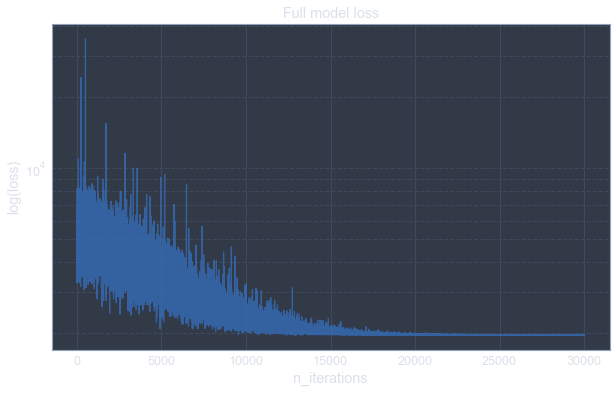

Full model results on the training set:
	MAE =  518465.8981540202
	MAPE =  -831734.4429478167
Full model results on the test set:
	MAE =  488083.00440688885
	MAPE =  -48461.668968112586


In [22]:
full_posterior = define_lin_reg(
    X_train_subset,
    y_train_scaled.ravel(),
    "full_model",
    alpha=("Normal", 0, 30),
    beta=("Normal", 0, 30),
    sigma=("HalfCauchy", 5),
    plot_loss=True,
)

print("Full model results on the training set:")
y_pred_train = evaluate(
    full_posterior, X_train_subset, y_train_scaled, y_scaler, "full_model", "train"
)

print("Full model results on the test set:")
y_pred_val = evaluate(
    full_posterior, X_test_subset, y_test_scaled, y_scaler, "full_model", "test"
)

## Clustering

Let's try all possible combinations of feature clustering to try to identify the 'pieces' of the data.

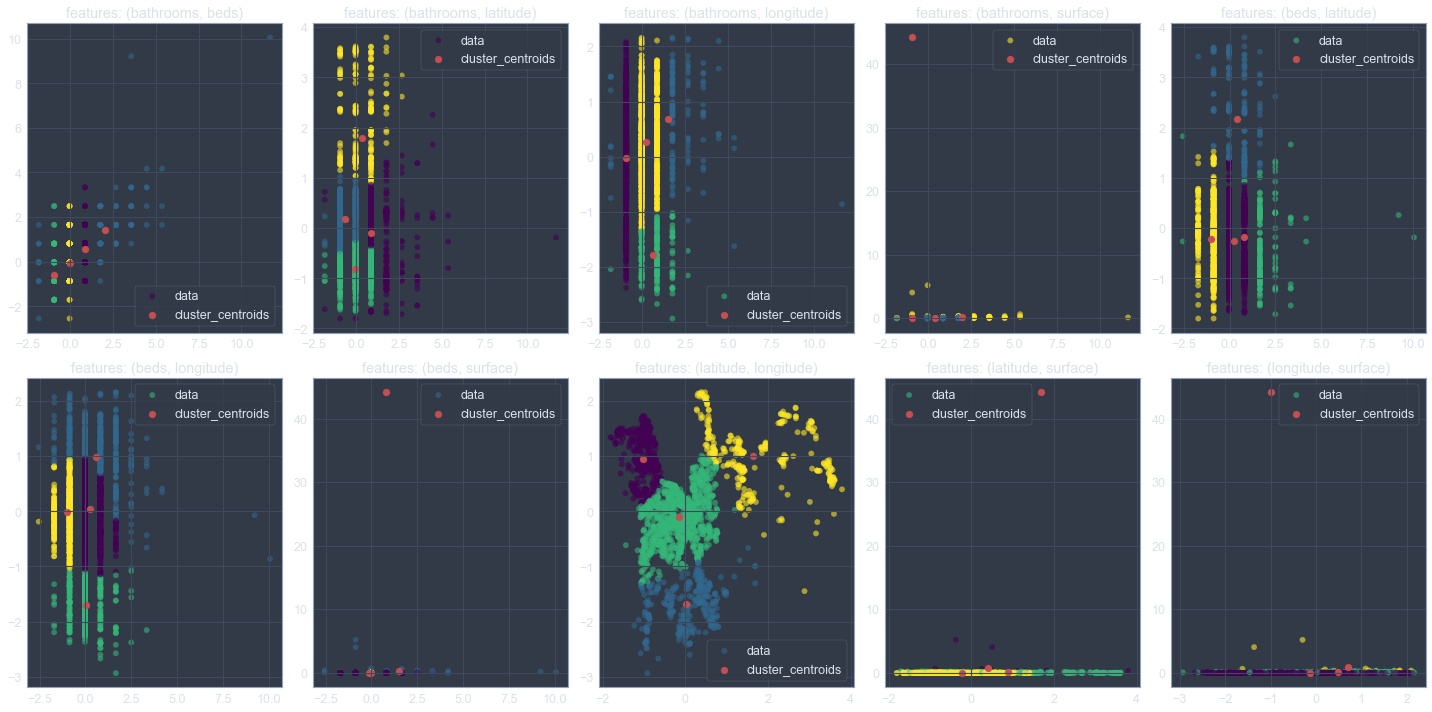

In [23]:
# training gaussian mixture model
from sklearn.mixture import GaussianMixture
from itertools import combinations

feat_names = train_set.columns.tolist()
# Ideally, create a cluster for each feature
n_clusters = 4
gmm = GaussianMixture(n_components=n_clusters)

feature_combinations = combinations(features, 2)
fig, axes = plt.subplots(2, 5, figsize=(20, 10))

for ax, feat_idx in zip(axes.flatten(), feature_combinations):
    X_clustering = np.r_[X_train_subset[:, feat_idx]]
    X_cluster_labels = gmm.fit_predict(X_clustering)

    ax.scatter(
        X_clustering[:, 0],
        X_clustering[:, 1],
        alpha=0.6,
        label="data",
        c=X_cluster_labels,
    )
    ax.scatter(
        gmm.means_[:, 0],
        gmm.means_[:, 1],
        s=50,
        c="r",
        marker="o",
        label="cluster_centroids",
    )
    name_1, name_2 = feat_idx
    ax.set_title(f"features: ({feat_names[name_1]}, {feat_names[name_2]})")
    ax.legend()
fig.tight_layout()
plt.show()

As suggested in the lecture, we'll use latitude and longitude (features 2, 3) to cluster the data points.

In [24]:
gmm = GaussianMixture(n_components=n_clusters)
feat_idx = [2, 3]

train_cluster_labels = gmm.fit_predict(X_train_subset[:, feat_idx])
test_cluster_labels = gmm.predict(X_test_subset[:, feat_idx])

In [25]:
# Training clusters
X_train_clusters = [
    X_train_subset[train_cluster_labels == idx] for idx in range(n_clusters)
]

y_scalers = [StandardScaler() for _ in range(n_clusters)]
y_train_clusters = [
    y_scaler.fit_transform(y_train[train_cluster_labels == idx].reshape(-1, 1))
    for idx, y_scaler in enumerate(y_scalers)
]

print("Training cluster shapes:")
print(
    "\n".join(
        f"\tX_{idx}={X.shape}, y_{idx}={y.shape}"
        for idx, (X, y) in enumerate(zip(X_train_clusters, y_train_clusters))
    ),
)

Training cluster shapes:
	X_0=(323, 5), y_0=(323, 1)
	X_1=(1016, 5), y_1=(1016, 1)
	X_2=(306, 5), y_2=(306, 1)
	X_3=(357, 5), y_3=(357, 1)


In [26]:
# Test clusters
X_test_clusters = [
    X_test_subset[test_cluster_labels == idx] for idx in range(n_clusters)
]
y_test_clusters = [
    y_test_scaled[test_cluster_labels == idx].ravel() for idx in range(n_clusters)
]

print("Test cluster shapes:")
print(
    "\n".join(
        f"\tX_{idx}={X.shape}, y_{idx}={y.shape}"
        for idx, (X, y) in enumerate(zip(X_test_clusters, y_test_clusters))
    ),
)

Test cluster shapes:
	X_0=(65, 5), y_0=(65,)
	X_1=(263, 5), y_1=(263,)
	X_2=(88, 5), y_2=(88,)
	X_3=(84, 5), y_3=(84,)


## Piecewise Models

In [27]:
posterior_0 = define_lin_reg(
    X_train_clusters[0], y_train_clusters[0].ravel(), "piece_0"
)
posterior_1 = define_lin_reg(
    X_train_clusters[1], y_train_clusters[1].ravel(), "piece_1"
)
posterior_2 = define_lin_reg(
    X_train_clusters[2], y_train_clusters[2].ravel(), "piece_2"
)
posterior_3 = define_lin_reg(
    X_train_clusters[3], y_train_clusters[3].ravel(), "piece_3"
)

posteriors = [
    posterior_0,
    posterior_1,
    posterior_2,
    posterior_3,
]

Finished [100%]: Average Loss = 319.65


Finished [100%]: Average Loss = 1,017.4


Finished [100%]: Average Loss = 273.62


Finished [100%]: Average Loss = 290.8


In [28]:
print("Piecewise evaluation on training set:\n")

for idx, (posterior, X, y, y_scaler) in enumerate(
    zip(posteriors, X_train_clusters, y_train_clusters, y_scalers)
):
    print(f"Cluster {idx}, size: {len(y)}")
    evaluate(posterior, X, y, y_scaler, f"piece_{idx}", "train")
all_posteriors = np.r_[posteriors]

Piecewise evaluation on training set:

Cluster 0, size: 323
	MAE =  376189.13849487796
	MAPE =  373328.907223082
Cluster 1, size: 1016
	MAE =  494612.3196020138
	MAPE =  3332726.2929983204
Cluster 2, size: 306
	MAE =  500116.9166043903
	MAPE =  2236713.984890722
Cluster 3, size: 357
	MAE =  742806.152337983
	MAPE =  267472.02496953006


In [29]:
print("Piecewise evaluation on test set:\n")

for idx, (posterior, X, y, y_scaler) in enumerate(
    zip(posteriors, X_test_clusters, y_test_clusters, y_scalers)
):
    print(f"Cluster {idx}, size: {len(y)}")
    evaluate(posterior, X, y, y_scaler, f"piece_{idx}", "test")
all_posteriors = np.r_[posteriors]

Piecewise evaluation on test set:

Cluster 0, size: 65
	MAE =  339668.0322993478
	MAPE =  -280429.40769485844
Cluster 1, size: 263
	MAE =  484052.39297853294
	MAPE =  -822898.82115019
Cluster 2, size: 88
	MAE =  247007687.21169946
	MAPE =  -43744887.1815543
Cluster 3, size: 84
	MAE =  726078.301355204
	MAPE =  537113.2007974291


In [32]:
mlflow.end_run()

## Simulations

First let's define some helper functions

In [30]:
# Posterior predictive checks (PPCs)
def ppc(posterior, X, n_samples=200):
    """Create n_samples predictions for X given a learned posterior.

    Parameters
    ----------
    posterior : pymc3.backends.base.MultiTrace.
        Posterior distribution estimated by pymc model.
    X : np.ndarray
        Features to use for the predictions
    n_samples : int, Optional
        Number of draws to take from the posterior
    Notes
    -----
    The posterior predictive check is done by sampling parameters from the posterior
    and generating a vector of outcomes bases on these parameters. The result is a
    matrix of shape SxN where S is the number of samples to draw from the posterior
    and N is the number of data points in the target y.
    """

    sample_idx = np.random.randint(
        0, len(posterior), size=n_samples
    )  # Indexes to sample from the posterior

    alpha_idx = posterior["alpha"][sample_idx].reshape(-1, 1)  # Shape (n_samples, 1)
    beta_idx = posterior["beta"][sample_idx, :]  # Shape (n_samples, n_features)
    sigma_idx = posterior["sigma"][sample_idx].reshape(-1, 1)  # Shape (n_samples, 1)

    # we generate data from linear model
    y_pred = (
        alpha_idx
        + np.dot(beta_idx, X.T)
        + np.random.randn(*sigma_idx.shape) * sigma_idx
    )
    assert y_pred.shape == (
        n_samples,
        len(X),
    )  # Final shape should be (n_samples, len(X))
    return y_pred


def plot_ppc(y_true, y_pred, ax, remove_legend, linewidth=0.2, alpha=0.3):
    """Generates a Posterior Predictive check plot, comparing predictions sampled
    from the learned posterior against the observed values.

    Parameters
    ----------
    y_true : np.ndarray
        The observed values.
    y_pred : np.ndarray
        Values predicted from the posterior
    ax : matplotlib.pyplot.axis
        The axes to plot
    remove_legend : bool
        Removes the axis legend if set to True
    linewidth : float, Optional
        Linewidth value for PPC plot
    alpha : float, Optional
        Alpha value for PPC plot
    """
    plot_kwargs = dict(linewidth=linewidth, alpha=alpha)

    # Plot the predictions
    for row in range(len(y_pred)):
        az.plot_dist(y_pred[row], color="lightblue", ax=ax, plot_kwargs=plot_kwargs)
    az.plot_dist(
        y_pred, color="lightblue", ax=ax, label="predictions", plot_kwargs=plot_kwargs,
    )

    # Plot the true data
    plot_kwargs.update({"linewidth": 0.9, "alpha": 0.8})
    az.plot_dist(
        y_true,
        color="#ff491c",
        ax=ax,
        label="true observations",
        plot_kwargs=plot_kwargs,
    )

    if remove_legend:
        ax.get_legend().remove()

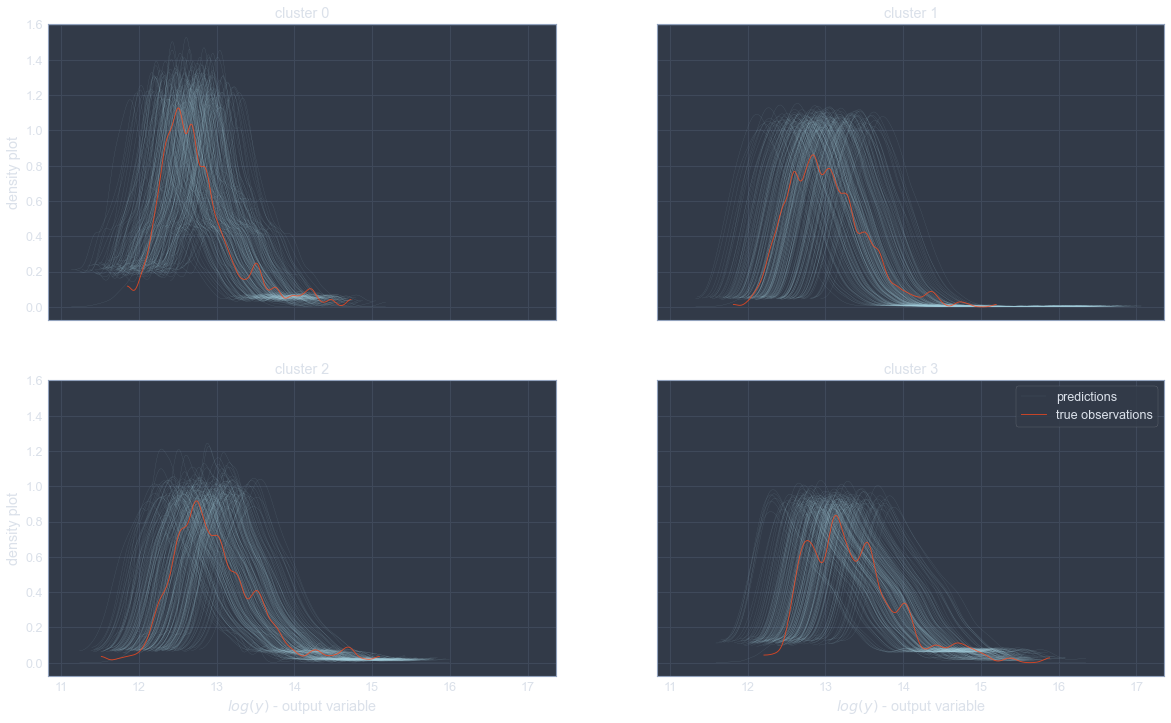

In [31]:
fig, axes = plt.subplots(2, 2, figsize=(20, 12), sharex=True, sharey=True)
piecewise_ppc = []
y_preds = []

for idx, ax in enumerate(axes.flatten()):
    idx_ppc = y_scalers[idx].inverse_transform(
        ppc(posteriors[idx], X_train_clusters[idx],)
    )
    piecewise_ppc.append(idx_ppc)

    # Plotting
    remove_legend = True if idx != n_clusters - 1 else False
    plot_ppc(
        y_scalers[idx].inverse_transform(y_train_clusters[idx]),
        idx_ppc,
        ax,
        remove_legend,
    )
    ax.set_title(f"cluster {idx}")
    if idx % 2 == 0:
        ax.set_ylabel("density plot")
    if idx > 1:
        ax.set_xlabel("$log({y})$ - output variable")
plt.show()

## Overall

## Test set performance

### PPC on the Test set



# SUMMARY